Processing dataset from t=0.0s to t=899.8s
Smart Alert System: 2-min cooldown, 80% threshold for continuous conditions
⚠️  ALERT #1 [SPO2_CRITICAL] at t=1.0s | Battery=99.9% | Size=372B
    → CRITICAL: SPO2 89.0% < 90%
⚠️  ALERT #2 [FALL] at t=2.0s | Battery=99.8% | Size=382B
    → FALL DETECTED: Accel 3.00g
⚠️  ALERT #3 [HR_CRITICAL_LOW] at t=18.5s | Battery=98.2% | Size=409B
    → CRITICAL: HR 53.8 < 60 bpm (Bradycardia)
📊 SUMMARY #4 at t=30.0s | Battery=98.5% | Size=264B | Compression=1.3%
📊 SUMMARY #5 at t=60.0s | Battery=95.5% | Size=237B | Compression=1.1%
📊 SUMMARY #6 at t=90.0s | Battery=92.5% | Size=249B | Compression=1.2%
📊 SUMMARY #7 at t=120.0s | Battery=89.5% | Size=251B | Compression=1.2%
⚠️  ALERT #8 [SPO2_CRITICAL] at t=121.0s | Battery=87.9% | Size=393B
    → CRITICAL: SPO2 87.0% < 90%
⚠️  ALERT #9 [FALL] at t=122.2s | Battery=87.8% | Size=388B
    → FALL DETECTED: Accel 3.00g
⚠️  ALERT #10 [HR_CRITICAL_LOW] at t=141.5s | Battery=85.8% | Size=408B
    → CRITICAL: HR 59

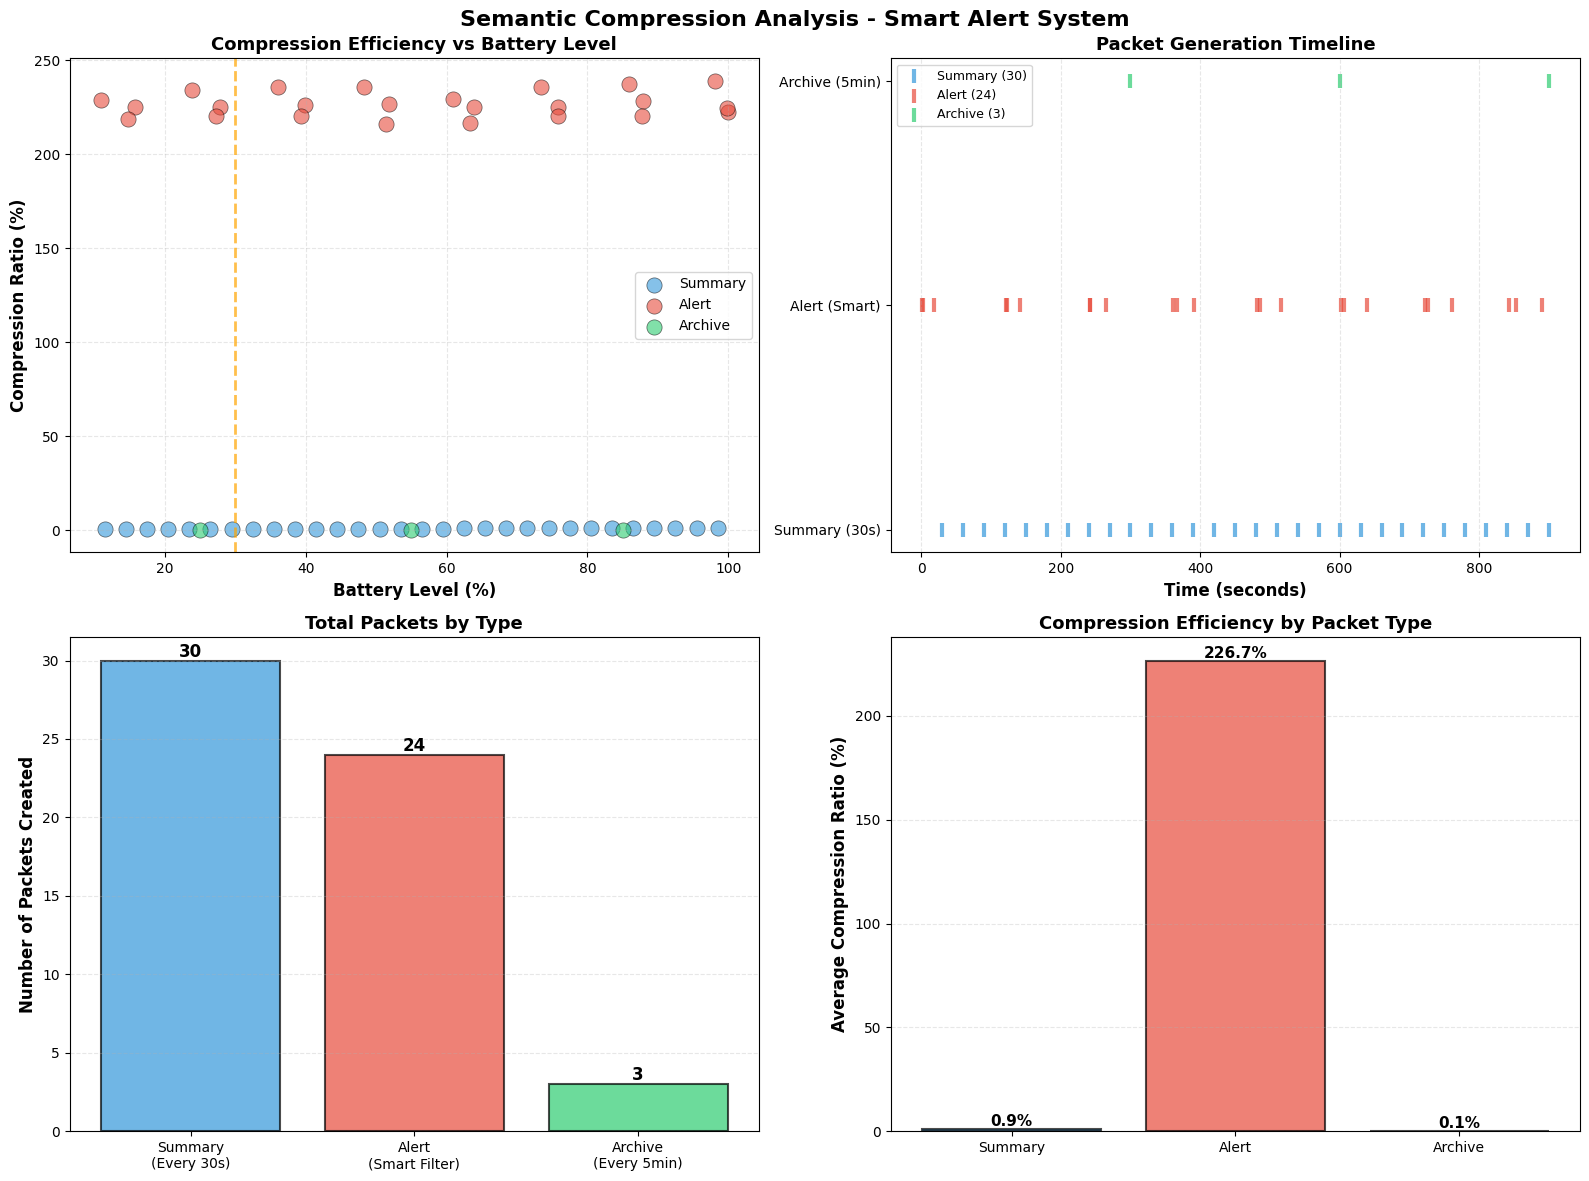


📈 Visualization complete!

💡 Smart Alert Features:
   ✓ 2-minute cooldown between same alert types
   ✓ HR: Warning if >100 for 2+ min (80% readings)
   ✓ HR: Critical if >120 OR <60 (immediate alerts)
   ✓ SPO2: Warning if 90-95% for 2+ min (80% readings), Critical if <90%
   ✓ Fall & Stress: Immediate alerts with cooldown
   ✓ Significantly reduced alert noise for semantic compression!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from collections import deque

# Load the dataset
df = pd.read_csv('health_dataset.csv')
numeric_cols = ['t', 'hr', 'eda', 'spo2', 'accel', 'ambient_temp', 'ambient_noise', 'Battery_level']
df[numeric_cols] = df[numeric_cols].astype(float)

# Create folders if they don't exist
for folder in ['summary', 'alert', 'archive']:
    os.makedirs(folder, exist_ok=True)

# Thresholds for alerts
HR_WARNING_HIGH = 100.0  # Warning threshold (needs 2 min continuous)
HR_CRITICAL_HIGH = 120.0  # Critical threshold (immediate alert)
HR_CRITICAL_LOW = 60.0   # Critical low threshold (immediate alert)
SPO2_WARNING_HIGH = 95.0  # Upper range for warning
SPO2_WARNING_LOW = 90.0   # Lower range for warning (needs 2 min continuous)
SPO2_CRITICAL = 90.0  # Critical threshold (immediate alert if below)
ACCEL_FALL = 2.0  # Immediate alert
EDA_HIGH = 1.0  # Immediate alert

ALERT_COOLDOWN = 120.0  # 2 minutes cooldown between same alert types

class AlertTracker:
    """Tracks alert conditions and manages cooldown periods"""
    def __init__(self):
        self.last_alert_time = {
            'hr_warning': -999,
            'hr_critical_high': -999,
            'hr_critical_low': -999,
            'spo2_warning': -999,
            'spo2_critical': -999,
            'fall': -999,
            'stress': -999
        }
        self.hr_window = deque(maxlen=120)  # 2 minutes at 1Hz = 120 readings
        self.spo2_window = deque(maxlen=120)

    def add_reading(self, hr, spo2, current_time):
        """Add new reading to sliding windows"""
        self.hr_window.append(hr)
        self.spo2_window.append(spo2)

    def check_hr_alerts(self, current_hr, current_time):
        """Check heart rate alert conditions"""
        alerts = []

        # Critical: HR > 120 (immediate alert)
        if current_hr > HR_CRITICAL_HIGH:
            if current_time - self.last_alert_time['hr_critical_high'] >= ALERT_COOLDOWN:
                alerts.append(('hr_critical_high', f"CRITICAL: HR {current_hr:.1f} > 120 bpm"))
                self.last_alert_time['hr_critical_high'] = current_time

        # Critical: HR < 60 (immediate alert - bradycardia)
        elif current_hr < HR_CRITICAL_LOW:
            if current_time - self.last_alert_time['hr_critical_low'] >= ALERT_COOLDOWN:
                alerts.append(('hr_critical_low', f"CRITICAL: HR {current_hr:.1f} < 60 bpm (Bradycardia)"))
                self.last_alert_time['hr_critical_low'] = current_time

        # Warning: HR > 100 for 2+ minutes (80% of readings)
        elif len(self.hr_window) >= 120:  # Have 2 minutes of data
            high_hr_count = sum(1 for hr in self.hr_window if hr > HR_WARNING_HIGH)
            if high_hr_count >= 96:  # 80% of 120 readings
                if current_time - self.last_alert_time['hr_warning'] >= ALERT_COOLDOWN:
                    alerts.append(('hr_warning', f"WARNING: HR > 100 for 2+ minutes (avg: {sum(self.hr_window)/len(self.hr_window):.1f})"))
                    self.last_alert_time['hr_warning'] = current_time

        return alerts

    def check_spo2_alerts(self, current_spo2, current_time):
        """Check SPO2 alert conditions"""
        alerts = []

        # Critical: SPO2 < 90 (immediate alert)
        if current_spo2 < SPO2_CRITICAL:
            if current_time - self.last_alert_time['spo2_critical'] >= ALERT_COOLDOWN:
                alerts.append(('spo2_critical', f"CRITICAL: SPO2 {current_spo2:.1f}% < 90%"))
                self.last_alert_time['spo2_critical'] = current_time

        # Warning: SPO2 in 90-95% range for 2+ minutes (80% of readings)
        elif len(self.spo2_window) >= 120:  # Have 2 minutes of data
            warning_range_count = sum(1 for spo2 in self.spo2_window
                                     if SPO2_WARNING_LOW <= spo2 <= SPO2_WARNING_HIGH)
            if warning_range_count >= 96:  # 80% of 120 readings
                if current_time - self.last_alert_time['spo2_warning'] >= ALERT_COOLDOWN:
                    alerts.append(('spo2_warning', f"WARNING: SPO2 in 90-95% range for 2+ minutes (avg: {sum(self.spo2_window)/len(self.spo2_window):.1f}%)"))
                    self.last_alert_time['spo2_warning'] = current_time

        return alerts

    def check_immediate_alerts(self, accel, eda, current_time):
        """Check immediate alert conditions (fall and stress)"""
        alerts = []

        # Fall detection
        if accel > ACCEL_FALL:
            if current_time - self.last_alert_time['fall'] >= ALERT_COOLDOWN:
                alerts.append(('fall', f"FALL DETECTED: Accel {accel:.2f}g"))
                self.last_alert_time['fall'] = current_time

        # High stress (EDA)
        if eda > EDA_HIGH:
            if current_time - self.last_alert_time['stress'] >= ALERT_COOLDOWN:
                alerts.append(('stress', f"HIGH STRESS: EDA {eda:.2f}"))
                self.last_alert_time['stress'] = current_time

        return alerts

def create_summary_packet(data_rows, current_time, packet_number):
    """Create summary packet with adaptive fields based on battery level"""
    if not data_rows:
        return None

    summary_df = pd.DataFrame(data_rows)
    avg_battery = float(summary_df['Battery_level'].mean())

    # Common fields
    summary_msg = {
        'packet_seq_number': packet_number,
        't': current_time,
        'device': summary_df['device_id'].iloc[0],
        'battery': avg_battery,
    }

    # Battery-based logic
    if avg_battery > 60.0:
        # High Battery → full info
        summary_msg.update({
            'hr': float(summary_df['hr'].mean()),
            'hr_min': float(summary_df['hr'].min()),
            'hr_max': float(summary_df['hr'].max()),
            'eda': float(summary_df['eda'].mean()),
            'spo2': float(summary_df['spo2'].mean()),
            'ambient_temp': float(summary_df['ambient_temp'].mean()),
            'ambient_noise': float(summary_df['ambient_noise'].mean())
        })
    elif 30.0 <= avg_battery <= 60.0:
        # Medium Battery → reduced info
        summary_msg.update({
            'hr': float(summary_df['hr'].mean()),
            'eda': float(summary_df['eda'].mean()),
            'spo2': float(summary_df['spo2'].mean())
        })
    else:
        # Low Battery → minimal info
        summary_msg.update({
            'hr': float(summary_df['hr'].mean()),
            'spo2': float(summary_df['spo2'].mean()),
            'accel': float(summary_df['accel'].mean())
        })

    # Compression stats
    compressed = json.dumps(summary_msg)
    original_size = sum(len(str(row)) for row in data_rows)
    compressed_size = len(compressed)
    ratio = (compressed_size / original_size) * 100 if original_size > 0 else 0

    return {
        'packet_number': packet_number,
        'packet_type': 'summary',
        'data': compressed,
        'original_size_bytes': original_size,
        'compressed_size_bytes': compressed_size,
        'compression_ratio': ratio,
        'timestamp': current_time,
        'battery': avg_battery
    }


def create_archive_packet(data_rows, current_time, packet_number):
    """Create archive packet with high compression (5-min averages)"""
    if not data_rows:
        return None

    archive_df = pd.DataFrame(data_rows)
    avg_battery = float(archive_df['Battery_level'].mean())

    archive_msg = {
        'packet_seq_number': packet_number,
        't': current_time,
        'device': archive_df['device_id'].iloc[0],
        'battery': avg_battery,
        'hr': float(archive_df['hr'].mean()),
        'eda': float(archive_df['eda'].mean()),
        'spo2': float(archive_df['spo2'].mean()),
        'accel': float(archive_df['accel'].mean())
    }

    # Battery-aware: skip ambient data if battery < 30%
    if avg_battery > 30.0:
        archive_msg['ambient_temp'] = float(archive_df['ambient_temp'].mean())
        archive_msg['ambient_noise'] = float(archive_df['ambient_noise'].mean())

    compressed = json.dumps(archive_msg)
    original_size = sum(len(str(row)) for row in data_rows)
    compressed_size = len(compressed)
    ratio = (compressed_size / original_size) * 100 if original_size > 0 else 0

    return {
        'packet_number': packet_number,
        'packet_type': 'archive',
        'data': compressed,
        'original_size_bytes': original_size,
        'compressed_size_bytes': compressed_size,
        'compression_ratio': ratio,
        'timestamp': current_time,
        'battery': avg_battery
    }

def create_alert_packet(row, alert_list, prior_data, current_time, packet_number):
    """Create alert packet with context"""
    if not alert_list:
        return None

    battery = row['Battery_level']

    alert_msg = {
        'packet_seq_number': packet_number,
        't': current_time,
        'device': row['device_id'],
        'battery': battery,
        'alerts': [alert[1] for alert in alert_list],  # Get alert messages
        'alert_types': [alert[0] for alert in alert_list],  # Get alert types
        'current_vitals': {
            'hr': float(row['hr']),
            'eda': float(row['eda']),
            'spo2': float(row['spo2']),
            'accel': float(row['accel'])
        }
    }

    # Include prior context for critical alerts
    if prior_data is not None and len(prior_data) > 0:
        alert_msg['prior_context'] = {
            'hr_avg': float(prior_data['hr'].mean()),
            'hr_min': float(prior_data['hr'].min()),
            'hr_max': float(prior_data['hr'].max()),
            'spo2_avg': float(prior_data['spo2'].mean()),
            'spo2_min': float(prior_data['spo2'].min()),
            'spo2_max': float(prior_data['spo2'].max())
        }

    compressed = json.dumps(alert_msg)
    original_size = len(str(row.to_dict()))
    compressed_size = len(compressed)
    ratio = (compressed_size / original_size) * 100 if original_size > 0 else 0

    return {
        'packet_number': packet_number,
        'packet_type': 'alert',
        'data': compressed,
        'original_size_bytes': original_size,
        'compressed_size_bytes': compressed_size,
        'compression_ratio': ratio,
        'timestamp': current_time,
        'battery': battery
    }

def process_dataset(df):
    """Process entire dataset with smart alert management"""

    # Initialize trackers and timers
    alert_tracker = AlertTracker()
    last_summary_time = 0.0
    last_archive_time = 0.0

    # Data buffers
    summary_buffer = []
    archive_buffer = []

    # Packet tracking
    all_packets = {'summary': [], 'alert': [], 'archive': []}
    global_packet_number = 0  # Global packet counter
    packet_log = []  # For CSV export

    print(f"Processing dataset from t={df['t'].min():.1f}s to t={df['t'].max():.1f}s")
    print(f"Smart Alert System: 2-min cooldown, 80% threshold for continuous conditions")
    print("="*70)

    for i in range(len(df)):
        row = df.iloc[i]
        current_time = row['t']

        # Add current row to buffers
        summary_buffer.append(row.to_dict())
        archive_buffer.append(row.to_dict())

        # Update alert tracker with current readings
        alert_tracker.add_reading(row['hr'], row['spo2'], current_time)

        # Check all alert conditions
        all_alerts = []

        # Check HR alerts
        all_alerts.extend(alert_tracker.check_hr_alerts(row['hr'], current_time))

        # Check SPO2 alerts
        all_alerts.extend(alert_tracker.check_spo2_alerts(row['spo2'], current_time))

        # Check immediate alerts (fall, stress)
        all_alerts.extend(alert_tracker.check_immediate_alerts(row['accel'], row['eda'], current_time))

        # Create alert packet if any alerts triggered
        if all_alerts:
            # Get prior 30 seconds of data for context
            prior_df = df[(df['t'] <= current_time) & (df['t'] > current_time - 30.0)]

            global_packet_number += 1
            alert_packet = create_alert_packet(row, all_alerts, prior_df, current_time, global_packet_number)
            if alert_packet:
                filename = f'alert_packet_{global_packet_number}_t{current_time:.1f}.json'
                filepath = os.path.join('alert', filename)
                with open(filepath, 'w') as f:
                    json.dump(alert_packet, f, indent=2)
                all_packets['alert'].append(alert_packet)

                # Log for CSV
                packet_log.append({
                    'packet_number': global_packet_number,
                    'packet_type': 'alert',
                    'timestamp': current_time,
                    'size_bytes': alert_packet['compressed_size_bytes'],
                    'compression_ratio': alert_packet['compression_ratio']
                })

                # Print alert details
                alert_types = ', '.join([a[0].upper() for a in all_alerts])
                print(f"⚠️  ALERT #{global_packet_number} [{alert_types}] at t={current_time:.1f}s | Battery={row['Battery_level']:.1f}% | Size={alert_packet['compressed_size_bytes']}B")
                for alert in all_alerts:
                    print(f"    → {alert[1]}")

        # Check for SUMMARY packet (every 30 seconds)
        if current_time - last_summary_time >= 30.0:
            global_packet_number += 1
            summary_packet = create_summary_packet(summary_buffer, current_time, global_packet_number)
            if summary_packet:
                filename = f'summary_packet_{global_packet_number}_t{current_time:.1f}.json'
                filepath = os.path.join('summary', filename)
                with open(filepath, 'w') as f:
                    json.dump(summary_packet, f, indent=2)
                all_packets['summary'].append(summary_packet)

                # Log for CSV
                packet_log.append({
                    'packet_number': global_packet_number,
                    'packet_type': 'summary',
                    'timestamp': current_time,
                    'size_bytes': summary_packet['compressed_size_bytes'],
                    'compression_ratio': summary_packet['compression_ratio']
                })

                print(f"📊 SUMMARY #{global_packet_number} at t={current_time:.1f}s | Battery={summary_packet['battery']:.1f}% | Size={summary_packet['compressed_size_bytes']}B | Compression={summary_packet['compression_ratio']:.1f}%")

                # Clear summary buffer and update timer
                summary_buffer = []
                last_summary_time = current_time

        # Check for ARCHIVE packet (every 300 seconds / 5 minutes)
        if current_time - last_archive_time >= 300.0:
            global_packet_number += 1
            archive_packet = create_archive_packet(archive_buffer, current_time, global_packet_number)
            if archive_packet:
                filename = f'archive_packet_{global_packet_number}_t{current_time:.1f}.json'
                filepath = os.path.join('archive', filename)
                with open(filepath, 'w') as f:
                    json.dump(archive_packet, f, indent=2)
                all_packets['archive'].append(archive_packet)

                # Log for CSV
                packet_log.append({
                    'packet_number': global_packet_number,
                    'packet_type': 'archive',
                    'timestamp': current_time,
                    'size_bytes': archive_packet['compressed_size_bytes'],
                    'compression_ratio': archive_packet['compression_ratio']
                })

                print(f"💾 ARCHIVE #{global_packet_number} at t={current_time:.1f}s | Battery={archive_packet['battery']:.1f}% | Size={archive_packet['compressed_size_bytes']}B | Compression={archive_packet['compression_ratio']:.1f}%")

                # Clear archive buffer and update timer
                archive_buffer = []
                last_archive_time = current_time

    # Process remaining data in buffers (final packets)
    final_time = df['t'].iloc[-1]

    if summary_buffer:
        global_packet_number += 1
        summary_packet = create_summary_packet(summary_buffer, final_time, global_packet_number)
        if summary_packet:
            filename = f'summary_packet_{global_packet_number}_t{final_time:.1f}_final.json'
            filepath = os.path.join('summary', filename)
            with open(filepath, 'w') as f:
                json.dump(summary_packet, f, indent=2)
            all_packets['summary'].append(summary_packet)
            packet_log.append({
                'packet_number': global_packet_number,
                'packet_type': 'summary',
                'timestamp': final_time,
                'size_bytes': summary_packet['compressed_size_bytes'],
                'compression_ratio': summary_packet['compression_ratio']
            })
            print(f"📊 FINAL SUMMARY #{global_packet_number} at t={final_time:.1f}s")

    if archive_buffer:
        global_packet_number += 1
        archive_packet = create_archive_packet(archive_buffer, final_time, global_packet_number)
        if archive_packet:
            filename = f'archive_packet_{global_packet_number}_t{final_time:.1f}_final.json'
            filepath = os.path.join('archive', filename)
            with open(filepath, 'w') as f:
                json.dump(archive_packet, f, indent=2)
            all_packets['archive'].append(archive_packet)
            packet_log.append({
                'packet_number': global_packet_number,
                'packet_type': 'archive',
                'timestamp': final_time,
                'size_bytes': archive_packet['compressed_size_bytes'],
                'compression_ratio': archive_packet['compression_ratio']
            })
            print(f"💾 FINAL ARCHIVE #{global_packet_number} at t={final_time:.1f}s")

    print("="*70)
    print(f"✅ Processing complete!")
    print(f"   Summary packets: {len(all_packets['summary'])}")
    print(f"   Alert packets: {len(all_packets['alert'])} (Smart filtering applied)")
    print(f"   Archive packets: {len(all_packets['archive'])}")
    print(f"   Total packets transmitted: {global_packet_number}")

    # Calculate total data savings
    total_original = sum(p['original_size_bytes'] for ptype in all_packets.values() for p in ptype)
    total_compressed = sum(p['compressed_size_bytes'] for ptype in all_packets.values() for p in ptype)
    total_saved = total_original - total_compressed
    savings_percent = (total_saved / total_original * 100) if total_original > 0 else 0

    print(f"\n📦 Data Transmission Summary:")
    print(f"   Original size: {total_original:,} bytes ({total_original/1024:.2f} KB)")
    print(f"   Compressed size: {total_compressed:,} bytes ({total_compressed/1024:.2f} KB)")
    print(f"   Data saved: {total_saved:,} bytes ({total_saved/1024:.2f} KB)")
    print(f"   Overall savings: {savings_percent:.1f}%")

    # Export to CSV for network simulation
    packet_df = pd.DataFrame(packet_log)
    csv_filename = 'packet_transmission_log.csv'
    packet_df.to_csv(csv_filename, index=False)
    print(f"\n📄 Packet log exported to: {csv_filename}")
    print(f"   Total entries: {len(packet_log)}")

    return all_packets, packet_df

# Process the dataset
all_packets, packet_df = process_dataset(df)

print("\n" + "="*70)
print("📊 Packet Transmission Log Preview:")
print("="*70)
print(packet_df.head(10).to_string(index=False))
if len(packet_df) > 10:
    print(f"\n... and {len(packet_df) - 10} more packets")
print("="*70)

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Semantic Compression Analysis - Smart Alert System', fontsize=16, fontweight='bold')

# Plot 1: Compression Ratio vs Battery Level (Color-coded by packet type)
ax1 = axes[0, 0]
colors_map = {'summary': '#3498db', 'alert': '#e74c3c', 'archive': '#2ecc71'}
for ptype in ['summary', 'alert', 'archive']:
    if all_packets[ptype]:
        batteries = [p['battery'] for p in all_packets[ptype]]
        ratios = [p['compression_ratio'] for p in all_packets[ptype]]
        ax1.scatter(batteries, ratios, label=ptype.capitalize(),
                   alpha=0.6, s=120, color=colors_map[ptype], edgecolors='black', linewidth=0.5)

ax1.set_xlabel('Battery Level (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Compression Ratio (%)', fontsize=12, fontweight='bold')
ax1.set_title('Compression Efficiency vs Battery Level', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.axvline(x=30, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Battery Threshold (30%)')

# Plot 2: Packet Creation Timeline
ax2 = axes[0, 1]
y_positions = {'summary': 1, 'alert': 2, 'archive': 3}
for ptype in ['summary', 'alert', 'archive']:
    if all_packets[ptype]:
        times = [p['timestamp'] for p in all_packets[ptype]]
        y_vals = [y_positions[ptype]] * len(times)
        ax2.scatter(times, y_vals, label=f"{ptype.capitalize()} ({len(times)})",
                   color=colors_map[ptype], alpha=0.7, s=100, marker='|', linewidth=3)

ax2.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_yticks([1, 2, 3])
ax2.set_yticklabels(['Summary (30s)', 'Alert (Smart)', 'Archive (5min)'], fontsize=10)
ax2.set_title('Packet Generation Timeline', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9, loc='upper left')
ax2.grid(True, alpha=0.3, axis='x', linestyle='--')

# Plot 3: Packet Distribution
ax3 = axes[1, 0]
packet_counts = [len(all_packets[ptype]) for ptype in ['summary', 'alert', 'archive']]
bars = ax3.bar(['Summary\n(Every 30s)', 'Alert\n(Smart Filter)', 'Archive\n(Every 5min)'],
               packet_counts, color=[colors_map[p] for p in ['summary', 'alert', 'archive']],
               alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Number of Packets Created', fontsize=12, fontweight='bold')
ax3.set_title('Total Packets by Type', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add count labels on bars
for bar, count in zip(bars, packet_counts):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 4: Average Compression Ratio by Packet Type
ax4 = axes[1, 1]
avg_ratios = []
packet_labels = []
for ptype in ['summary', 'alert', 'archive']:
    if all_packets[ptype]:
        avg_ratio = sum(p['compression_ratio'] for p in all_packets[ptype]) / len(all_packets[ptype])
        avg_ratios.append(avg_ratio)
        packet_labels.append(ptype.capitalize())

if avg_ratios:
    bars = ax4.bar(packet_labels, avg_ratios,
                   color=[colors_map[p] for p in ['summary', 'alert', 'archive']],
                   alpha=0.7, edgecolor='black', linewidth=1.5)
    ax4.set_ylabel('Average Compression Ratio (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Compression Efficiency by Packet Type', fontsize=13, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y', linestyle='--')

    # Add percentage labels on bars
    for bar, ratio in zip(bars, avg_ratios):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{ratio:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("📈 Visualization complete!")
print("="*70)
print("\n💡 Smart Alert Features:")
print("   ✓ 2-minute cooldown between same alert types")
print("   ✓ HR: Warning if >100 for 2+ min (80% readings)")
print("   ✓ HR: Critical if >120 OR <60 (immediate alerts)")
print("   ✓ SPO2: Warning if 90-95% for 2+ min (80% readings), Critical if <90%")
print("   ✓ Fall & Stress: Immediate alerts with cooldown")
print("   ✓ Significantly reduced alert noise for semantic compression!")
print("="*70)